## Наш план
На основе предоставленных данных и контекста задачи хакатона, нашей задачей является разработка сервиса по построению торговых решений на основе данных AlgoPack для помощи пользователям в более успешном инвестировании. Вот наши шаги:

###1 Анализ данных: Провесьти более глубокий анализ предоставленных данных, чтобы понять особенности рынка и торговых инструментов, таких как акции SBER и другие финансовые инструменты.

### 2Разработка модели: Использовать данные AlgoPack для создания модели, способной предсказывать будущие движения цен или другие параметры рынка. Это может включать в себя использование методов машинного обучения или статистических методов.

###3 Тестирование и оптимизация: Тестировать разработанную модель на исторических данных, чтобы оценить ее эффективность. В случае необходимости внести изменения и оптимизировать модель.

###4 Интеграция с платформой: Интегрировать наш сервис с платформой, на которой пользователи будут иметь доступ к торговым решениям и рекомендациям, основанным на разработанной модели.

###5 Разработка пользовательского интерфейса: Создать удобный интерфейс для пользователей, который позволит им легко взаимодействовать с нашим сервисом, получать рекомендации и управлять своими инвестициями.

###6 Управление рисками: Рассмотреть вопросы управления рисками в разрабатываемом сервисе. Это может включать в себя реализацию стратегий управления портфелем и другие меры по снижению потенциальных убытков.

###7 Обеспечение безопасности: Обеспечить безопасность данных и транзакций пользователей на платформе, соблюдая стандарты безопасности финансовых данных.

###8 Тестирование и обратная связь: Провеcти тестирование сервиса, а затем соберите обратную связь от пользователей, чтобы улучшить его производительность и функциональность.

In [1]:
# Необходимые библиотеки
# !pip install tensorflow pandas scikit-learn matplotlib pandas_ta moexalgo

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from moexalgo import Market, Ticker

stocks = Market('stocks')

# Акции SBER
sber = Ticker('SBER')
# Акции OZON
ozon = Ticker('OZON')
# Акции TATNEFT
tatneft = Ticker('TATN')
# Акции YNDX
yandex = Ticker('YNDX')
# Акции GAZP
gazprom = Ticker('GAZP')

In [ ]:
company = [sber, ozon, tatneft, yandex, gazprom]
company_to_save = ["sber", "ozon", "tatneft", "yandex", "gazprom"]
trade = company[0].tradestats(date='2023-12-01', till_date='2023-12-07')
trade.rename(columns={'systime':'systime_trade'}, inplace=True)
order = company[0].orderstats(date='2023-12-01', till_date='2023-12-07')
order.rename(columns={'systime':'systime_order'}, inplace=True)
obs = company[0].obstats(date='2023-12-01', till_date='2023-12-07')
obs.rename(columns={'val_b':'val_b_obs', 'val_s':'val_s_obs', 'vol_b':'vol_b_obs', 'vol_s':'vol_s_obs',
                    'systime':'systime_obs'}, inplace=True)

data = pd.merge(trade, order, on=['ticker','tradedate', 'tradetime'])
data = pd.merge(data, obs, on=['ticker','tradedate', 'tradetime'])
data.head()

,ticker,tradedate,tradetime,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,...,val_s_obs,imbalance_vol_bbo,imbalance_val_bbo,imbalance_vol,imbalance_val,vwap_b,vwap_s,vwap_b_1mio,vwap_s_1mio,systime_obs
0,SBER,2023-12-01,10:05:00,277.04,277.86,276.67,277.31,0.0001,80741,223654120.0,...,1007597537,0.16,0.16,-0.26,-0.28,271.51,285.36,276.93,277.00,2023-12-01 10:07:18
1,SBER,2023-12-01,10:10:00,277.32,277.39,276.30,276.36,0.0001,69886,193436342.0,...,1039833784,0.22,0.22,-0.25,-0.28,271.46,285.34,276.79,276.82,2023-12-01 10:10:12
2,SBER,2023-12-01,10:15:00,276.37,276.52,275.83,275.88,0.0001,60859,168015549.0,...,1063627774,0.02,0.02,-0.27,-0.29,271.08,285.26,276.03,276.07,2023-12-01 10:15:12
3,SBER,2023-12-01,10:20:00,275.87,276.25,275.86,276.15,0.0001,49739,137312544.0,...,1083742882,0.04,0.04,-0.21,-0.23,271.42,285.12,276.03,276.07,2023-12-01 10:20:12
4,SBER,2023-12-01,10:25:00,276.15,276.16,275.60,275.61,0.0000,53842,148521770.0,...,1103724006,0.21,0.21,-0.20,-0.22,271.50,284.98,275.89,275.91,2023-12-01 10:25:12


### Оценка важности признаков

## RandomForestRegressor metod

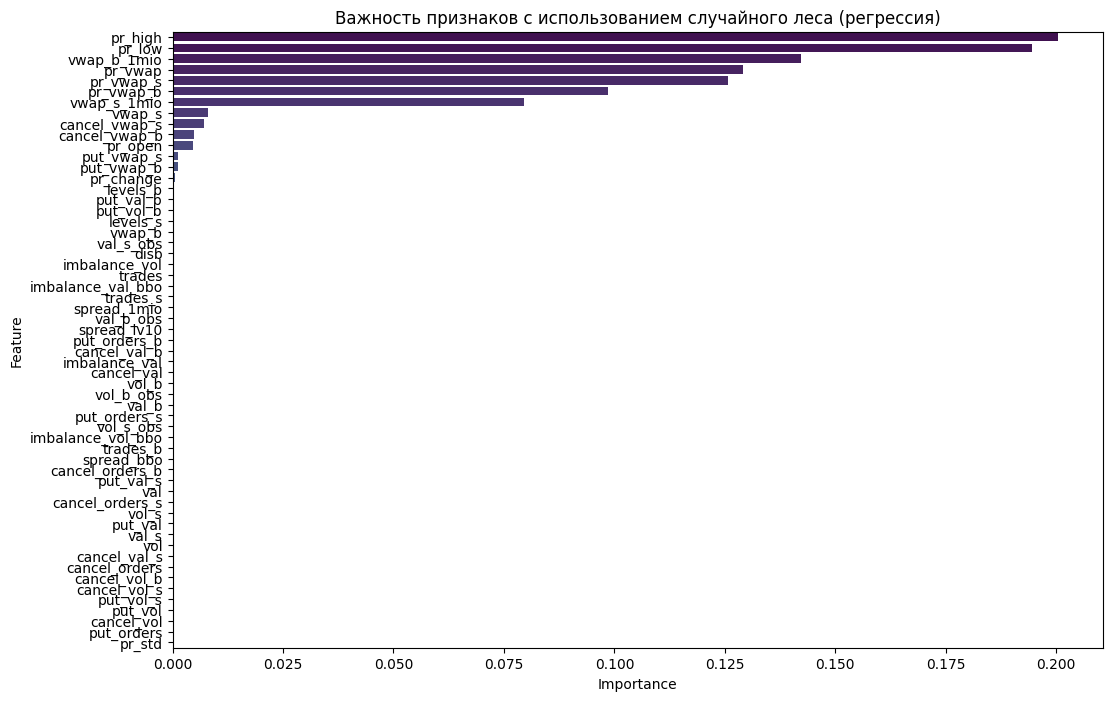

In [ ]:
exclude_columns = ['ticker', 'tradedate','tradetime', 'systime_trade',
                   'systime_order', 'systime_obs']
data_ = data.copy()

# Преобразование 'tradedate' в формат datetime
data_['tradedate'] = pd.to_datetime(data_['tradedate'])

# Преобразование 'tradetime' в формат datetime.time
data_['tradetime'] = pd.to_datetime(data_['tradetime'], format='%H:%M:%S').dt.time

# Создание нового столбца 'datetime' из 'tradedate' и 'tradetime'
data_['datetime'] = pd.to_datetime(data_['tradedate'].astype(str) + ' ' + data_['tradetime'].astype(str))

data_['datetime'] = data_['datetime'] + pd.to_timedelta('7 days')

# Удаление старых столбцов 'tradedate' и 'tradetime', если они больше не нужны
data_ = data_.drop(columns=['tradedate', 'tradetime'])

data = data.drop(columns=exclude_columns)

# Задайте целевой столбец
target_column = 'pr_close'

# Выделите целевой столбец и признаки
X = data.drop(columns=[target_column])
y = data[target_column]

# Создание модели случайного леса для регрессии
rf_model = RandomForestRegressor(random_state=42)

# Обучение модели и оценка важности признаков
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_

# Визуализация важности признаков
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Важность признаков с использованием случайного леса (регрессия)')
plt.show()

## Метод одномерного анализа вариации (ANOVA):
Описание: Оценивает, насколько средние значения зависимой переменной различаются между разными группами, обусловленными значениями одного из признаков.
Важность: Признаки с высоким F-статистикой и низким p-value считаются более важными.

In [ ]:
# X - признаки, y - целевая переменная
f_scores, p_values = f_classif(X, y)
anova_importance_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'P-Value': p_values})
anova_importance_df = anova_importance_df.sort_values(by='F-Score', ascending=False)
print(anova_importance_df.head(10))

        Feature     F-Score        P-Value
7       pr_vwap  458.074782  1.245137e-122
17    pr_vwap_s  453.965453  2.050330e-122
16    pr_vwap_b  435.250336  2.107206e-121
56  vwap_s_1mio  347.762865  5.188599e-116
55  vwap_b_1mio  328.127314  1.290382e-114
2        pr_low  312.839935  1.803812e-113
1       pr_high  166.261468   2.555997e-98
0       pr_open   82.863613   1.022792e-81
40   spread_bbo   42.381279   6.670552e-66
53       vwap_b   11.938449   3.724964e-37


## Метод взаимной информации:
Описание: Измеряет количество информации, которое одна переменная сообщает о другой. В контексте машинного обучения, это показывает, насколько хорошо признак предсказывает целевую переменную.
Важность: Чем выше значение взаимной информации, тем более важен признак.

In [ ]:
mi_scores = mutual_info_regression(X, y)
mi_importance_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_importance_df = mi_importance_df.sort_values(by='MI Score', ascending=False)
print(mi_importance_df.head(10))

        Feature  MI Score
7       pr_vwap  2.740439
17    pr_vwap_s  2.730993
16    pr_vwap_b  2.729607
56  vwap_s_1mio  2.689971
55  vwap_b_1mio  2.683101
1       pr_high  2.656568
2        pr_low  2.648446
0       pr_open  2.042592
53       vwap_b  1.761956
54       vwap_s  1.446667


## Пермутационные важности:
Описание: Оценивает важность признаков путем случайных перестановок значений целевой переменной и измерения изменения в качестве модели.
Важность: Признаки, при изменении которых качество модели сильно ухудшается, считаются более важными.

In [ ]:
perm_importance = permutation_importance(rf_model, X, y, n_repeats=30, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
print(perm_importance_df.head(10))

          Feature  Importance
2          pr_low    0.054449
1         pr_high    0.054259
55    vwap_b_1mio    0.037401
17      pr_vwap_s    0.034199
7         pr_vwap    0.025851
56    vwap_s_1mio    0.019750
16      pr_vwap_b    0.019282
54         vwap_s    0.001555
36  cancel_vwap_s    0.001517
35  cancel_vwap_b    0.000790


## Отбираем наиболее значимые признаки

In [ ]:
fi = list(feature_importance_df[0:10]['Feature'].values)
ai = list(anova_importance_df[0:10]['Feature'].values)
mi = list(mi_importance_df[0:10]['Feature'].values)
pi = list(perm_importance_df[0:10]['Feature'].values)
# la = list(lasso_importance_df[0:5]['Feature'].values)
result = list(set(fi) & set(ai) & set(mi) & set(pi))
result
# fi, ai, mi, pi, la

['pr_vwap_b',
 'pr_high',
 'pr_vwap_s',
 'vwap_s_1mio',
 'pr_vwap',
 'vwap_b_1mio',
 'pr_low']

In [ ]:
# Создание целевой переменной (target) - прогноз цены закрытия на следующем временном интервале
data_['target'] = data_['pr_close'].shift(-1)

# Удаление последней строки, так как у нее нет целевой переменной
candles_data = data_[:-1]

# Выбор признаков (features)
features = candles_data[result]

# Нормализация данных
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Создание последовательности данных для LSTM
def create_sequences(data_, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data_) - sequence_length):
        sequences.append(data_[i:i+sequence_length])
        targets.append(data_[i+sequence_length, 0])  # Используем только первый столбец
    return np.array(sequences), np.array(targets)

sequence_length = 10  # длина последовательности
X, y = create_sequences(scaled_features, sequence_length)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Исправлено количество признаков
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Получение прогнозов на будущий месяц
future_features = data_[result]
scaled_future_features = scaler.transform(future_features)

# Преобразование в последовательности
X_future, y_future = create_sequences(scaled_future_features, sequence_length)

# Получение прогнозов
future_predictions = model.predict(X_future)

# Инвертирование нормализации для визуализации результатов
scaled_inv = scaler.inverse_transform(scaled_future_features)

# Преобразование даты в формат datetime
# data_['tradetime'] = pd.to_datetime(data_['tradetime'])
data_.set_index('datetime', inplace=True)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(data_.index[:len(scaled_inv)], scaled_inv[:, 0], label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Создание DataFrame для прогнозов
future_predictions_df = pd.DataFrame({
    'Stock': data_['ticker'],
    'Date': data_.index[:len(scaled_inv)],
    'Predicted_Сlose': scaled_inv[:, 0]
})

# Сохранение DataFrame в CSV файл
# future_predictions_df.to_csv('sber_five_minut.csv', index=False)

16/16 [==============================] - 0s 3ms/step


##1 Стратегия скользящих средних:

Скользящие средние для определения тренда.
Покупка актива, когда короткий период скользящей средней пересекает длинный период вверх, и продажа, когда он пересекает вниз.

In [ ]:
# Преобразование в формат datetime
# future_predictions_df['Date'] = pd.to_datetime(future_predictions_df['Date'])
future_predictions_df['short_ma'] = future_predictions_df['Predicted_Сlose'].rolling(window=20).mean()
future_predictions_df['long_ma'] = future_predictions_df['Predicted_Сlose'].rolling(window=50).mean()

# Сигналы покупки и продажи
future_predictions_df['signal_rol'] = 0
future_predictions_df.loc[future_predictions_df['short_ma'] > future_predictions_df['long_ma'], 'signal_rol'] = 1
future_predictions_df.loc[future_predictions_df['short_ma'] < future_predictions_df['long_ma'], 'signal_rol'] = -1

future_predictions_df = future_predictions_df.drop(columns=['short_ma', 'long_ma'])

future_predictions_df.to_csv(f"{company_to_save[0]}.csv", index=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_df['Date'], future_predictions_df['Predicted_Сlose'], label='Close Price')
plt.scatter(future_predictions_df.loc[future_predictions_df['signal_rol'] == 'buy', 'Date'], future_predictions_df.loc[future_predictions_df['signal_rol'] == 'buy', 'Predicted_Сlose'], marker='^', color='g', label='Buy Signal')
plt.scatter(future_predictions_df.loc[future_predictions_df['signal_rol'] == 'sel', 'Date'], future_predictions_df.loc[future_predictions_df['signal_rol'] == 'sel', 'Predicted_Сlose'], marker='v', color='r', label='Sell Signal')
plt.plot(future_predictions_df['Date'], future_predictions_df['short_ma'], label='Short MA')
plt.plot(future_predictions_df['Date'], future_predictions_df['long_ma'], label='Long MA')
plt.legend()
plt.title(future_predictions_df['ticker'].values[0])
plt.xlabel('Time')
plt.ylabel('Predicted_Сlose')
plt.show()

In [ ]:
df = future_predictions_df
df['position'] = df['signal_rol'].diff()

# Рассчет прибыли/убытка за каждый период
df['profit_loss'] = df['position'] * df['Predicted_Сlose']

# Суммирование прибыли/убытка для получения общей прибыли/убытка
total_profit_loss = round(df['profit_loss'].sum(), 2)
total_profit_loss

258.49

### Backtest

TypeError: ignored

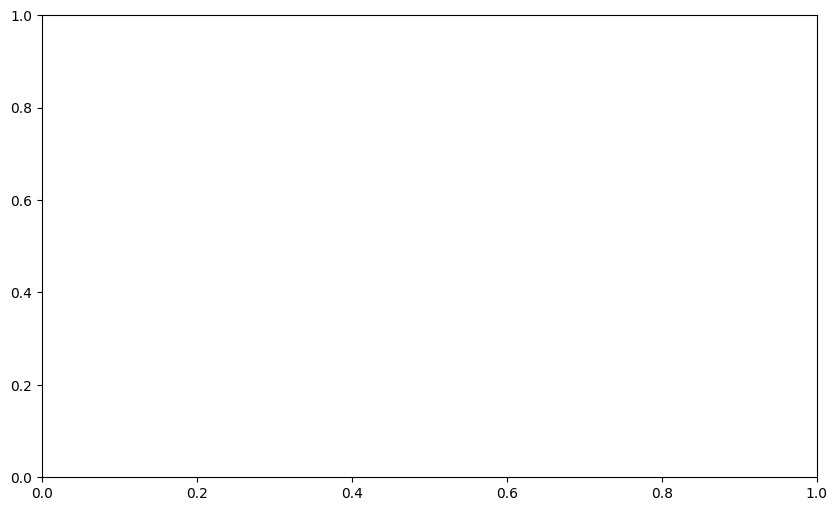

In [ ]:
# Рассчет процентного изменения цен закрытия
future_predictions_df['returns'] = future_predictions_df['Predicted_Сlose'].pct_change()
future_predictions_df['returns'] = future_predictions_df['returns'].fillna(0)
# Расчет доходности по стратегии
future_predictions_df['strategy_returns'] = future_predictions_df['signal_rol'].shift(1) * future_predictions_df['returns']

# Кумулятивная доходность
future_predictions_df['cumulative_strategy_returns'] = (1 + future_predictions_df['strategy_returns']).cumprod()

# Кумулятивная доходность без стратегии (купи и держи)
future_predictions_df['cumulative_buy_hold_returns'] = (1 + future_predictions_df['returns']).cumprod()

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_df['Date'], future_predictions_df['cumulative_strategy_returns'], label='Cumulative Strategy Returns', marker='o', linestyle='-', markersize=2, drawstyle='steps-post')
plt.plot(future_predictions_df['Date'], future_predictions_df['cumulative_buy_hold_returns'], label='Cumulative Buy and Hold Returns', marker='o', linestyle='-', markersize=2, drawstyle='steps-post')
plt.legend()
plt.title(data['ticker'].values[0])
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.show()

##2 Относительная сила (RSI) стратегия:

Индикатор относительной силы для определения перекупленности или перепроданности рынка.
Покупка актива, когда RSI падает ниже 30, и продажа, когда RSI поднимается выше 70.

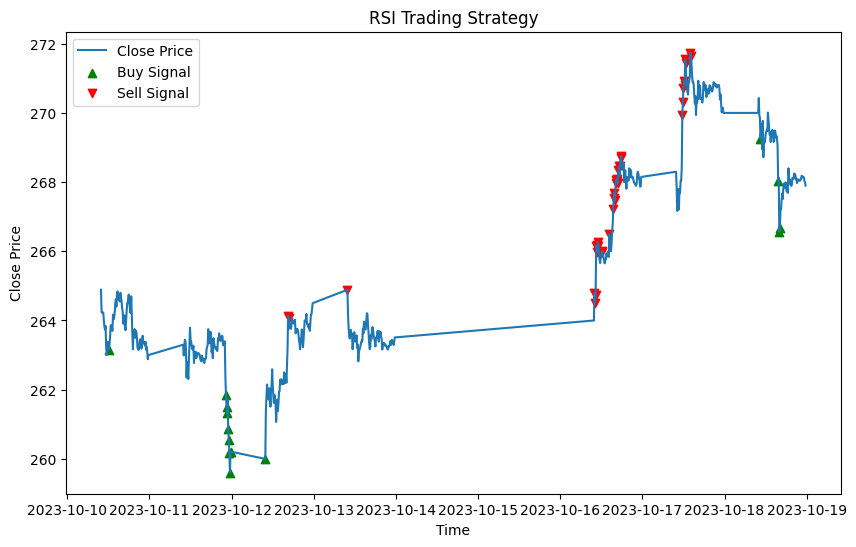

In [ ]:
import pandas_ta as ta

future_predictions_df['rsi'] = ta.rsi(future_predictions_df['close'], length=14)

# Signals for buy and sell based on RSI
future_predictions_df['signal_rsi'] = 0
future_predictions_df.loc[future_predictions_df['rsi'] < 30, 'signal_rsi'] = 'buy'
future_predictions_df.loc[future_predictions_df['rsi'] > 70, 'signal_rsi'] = 'sel'

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_df['begin'], future_predictions_df['close'], label='Close Price')
plt.scatter(future_predictions_df.loc[future_predictions_df['signal_rsi'] == 'buy', 'begin'], future_predictions_df.loc[future_predictions_df['signal_rsi'] == 'buy', 'close'], marker='^', color='g', label='Buy Signal')
plt.scatter(future_predictions_df.loc[future_predictions_df['signal_rsi'] == 'sel', 'begin'], future_predictions_df.loc[future_predictions_df['signal_rsi'] == 'sel', 'close'], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title('RSI Trading Strategy')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

### Backtest

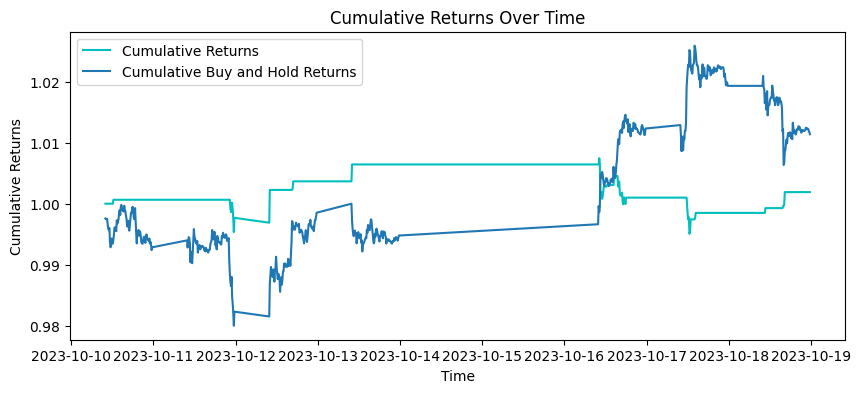

In [ ]:
data['begin'] = pd.to_datetime(data['begin'])  # Преобразование в формат datetime
data['rsi'] = ta.rsi(data['close'], length=14)

# Сигналы для покупки и продажи на основе RSI
data['signal_rsi'] = 0
data.loc[data['rsi'] < 30, 'signal_rsi'] = 'buy'
data.loc[data['rsi'] > 70, 'signal_rsi'] = 'sell'

# Создание колонки 'position'
data.loc[:, 'position'] = np.where(data['signal_rsi'] == 'buy', 1, np.where(data['signal_rsi'] == 'sell', -1, 0))

# Рассчет ежедневных доходностей
data.loc[:, 'daily_returns'] = data['close'].pct_change() * data['position'].shift(1)

# Рассчет кумулятивных доходностей
data.loc[:, 'cumulative_returns'] = (1 + data['daily_returns']).cumprod()

# Вывод кумулятивных доходностей
plt.figure(figsize=(10, 4))
plt.plot(data['begin'], data['cumulative_returns'], label='Cumulative Returns', color='c')
plt.plot(data['begin'], data['cumulative_buy_hold_returns'], label='Cumulative Buy and Hold Returns')
plt.legend()
plt.title('Cumulative Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

plt.show()

##3 MACD (Moving Average Convergence Divergence) стратегия:

Индикатор MACD для выявления силы и направления тренда.
Покупка актива, когда линия MACD пересекает сигнальную линию вверх, и продажа, когда она пересекает вниз.

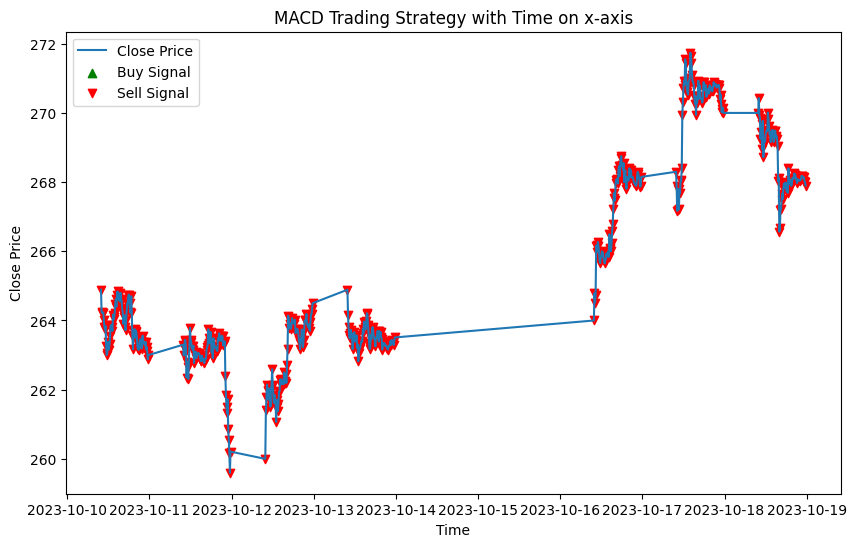

In [ ]:
data['begin'] = pd.to_datetime(data['begin'])  # Convert to datetime format
data['macd'], data['signal_line'], _ = ta.macd(data['close'], fast=12, slow=26, signal=9)

# Signals for buying and selling
data['signal_macd'] = 0
data.loc[data['macd'] > data['signal_line'], 'signal_macd'] = 'buy'
data.loc[data['macd'] < data['signal_line'], 'signal_macd'] = 'sel'

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(data['begin'], data['close'], label='Close Price')
plt.scatter(data.loc[data['signal_macd'] == 'buy', 'begin'], data.loc[data['signal_macd'] == 'buy', 'close'], marker='^', color='g', label='Buy Signal')
plt.scatter(data.loc[data['signal_macd'] == 'sel', 'begin'], data.loc[data['signal_macd'] == 'sel', 'close'], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title('MACD Trading Strategy with Time on x-axis')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

### Backtest

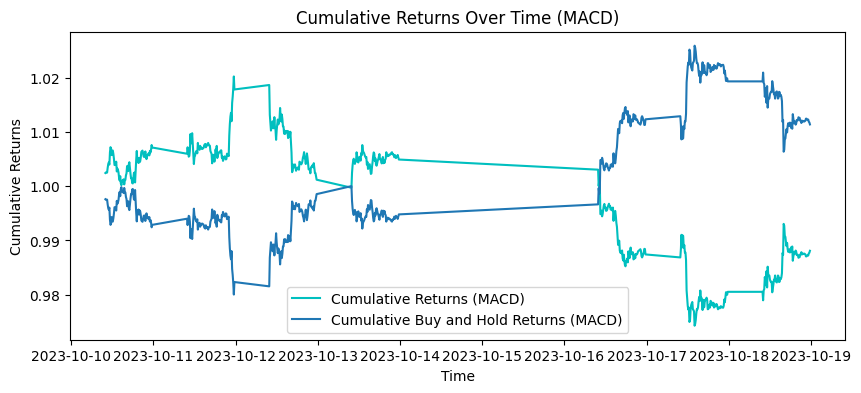

In [ ]:
data['begin'] = pd.to_datetime(data['begin'])  # Преобразование в формат datetime
data['macd'], data['signal_line'], _ = ta.macd(data['close'], fast=12, slow=26, signal=9)

# Сигналы для покупки и продажи на основе MACD
data['signal_macd'] = 0
data.loc[data['macd'] > data['signal_line'], 'signal_macd'] = 'buy'
data.loc[data['macd'] < data['signal_line'], 'signal_macd'] = 'sell'

# Создание колонки 'position'
data.loc[:, 'position_macd'] = np.where(data['signal_macd'] == 'buy', 1, np.where(data['signal_macd'] == 'sell', -1, 0))

# Рассчет ежедневных доходностей
data.loc[:, 'daily_returns_macd'] = data['close'].pct_change() * data['position_macd'].shift(1)

# Рассчет кумулятивных доходностей
data.loc[:, 'cumulative_returns_macd'] = (1 + data['daily_returns_macd']).cumprod()

# Вывод кумулятивных доходностей
plt.figure(figsize=(10, 4))
plt.plot(data['begin'], data['cumulative_returns_macd'], label='Cumulative Returns (MACD)', color='c')
plt.plot(data['begin'], data['cumulative_buy_hold_returns'], label='Cumulative Buy and Hold Returns (MACD)')
plt.legend()
plt.title('Cumulative Returns Over Time (MACD)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.show()

##4 Стратегия моментума:
Относительная сила цен или другие моментум-индикаторы для определения силы текущего тренда.
Покупка актива, когда моментум растет, и продажа, когда он снижается.

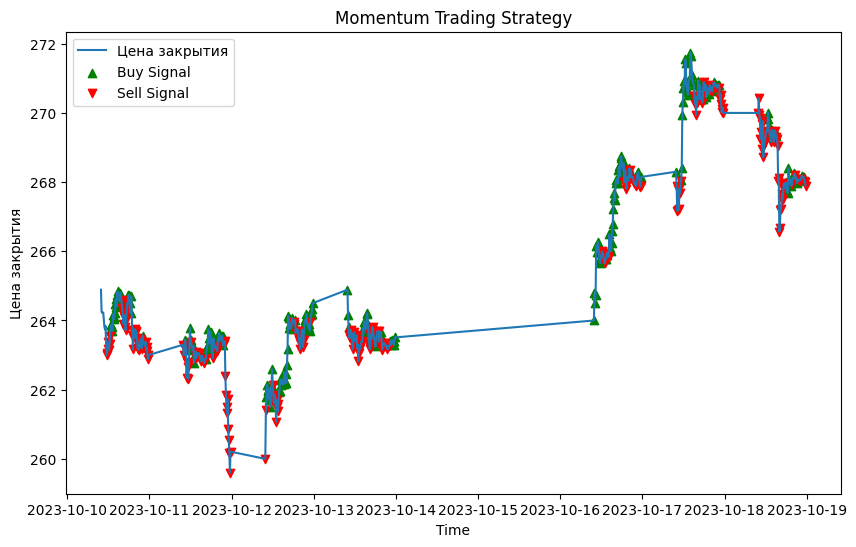

In [ ]:
data['begin'] = pd.to_datetime(data['begin'])  # Convert to datetime format
data['momentum'] = data['close'] - data['close'].shift(10)  # Пример использования 10-периодного моментума

# Сигналы для покупки и продажи
data['signal_mom'] = 0
data.loc[data['momentum'] > 0, 'signal_mom'] = 'buy'
data.loc[data['momentum'] < 0, 'signal_mom'] = 'sel'

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(data['begin'], data['close'], label='Цена закрытия')
plt.scatter(data.loc[data['signal_mom'] == 'buy', 'begin'], data.loc[data['signal_mom'] == 'buy', 'close'], marker='^', color='g', label='Buy Signal')
plt.scatter(data.loc[data['signal_mom'] == 'sel', 'begin'], data.loc[data['signal_mom'] == 'sel', 'close'], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title('Momentum Trading Strategy')
plt.xlabel('Time')
plt.ylabel('Цена закрытия')
plt.show()

### Backtest

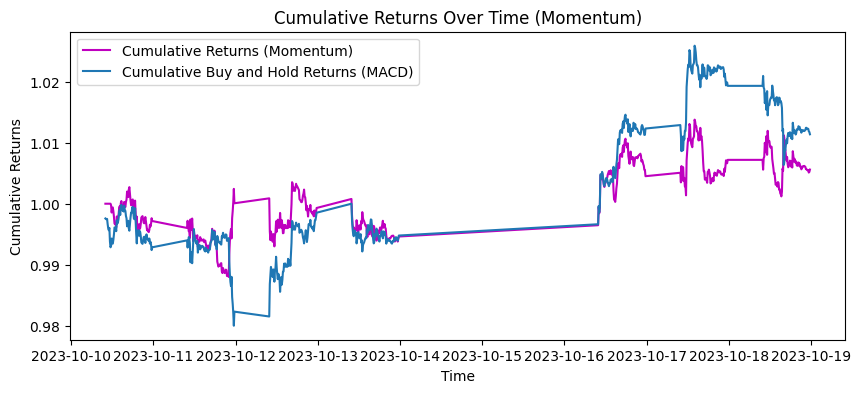

In [ ]:
# Предполагая, что у вас есть DataFrame 'data' с колонками 'begin', 'close' и 'signal_mom'
data['begin'] = pd.to_datetime(data['begin'])  # Преобразование в формат datetime
data['momentum'] = data['close'] - data['close'].shift(10)  # Пример использования 10-периодного моментума

# Сигналы для покупки и продажи на основе моментума
data['signal_mom'] = 0
data.loc[data['momentum'] > 0, 'signal_mom'] = 'buy'
data.loc[data['momentum'] < 0, 'signal_mom'] = 'sell'

# Создание колонки 'position'
data.loc[:, 'position_mom'] = np.where(data['signal_mom'] == 'buy', 1, np.where(data['signal_mom'] == 'sell', -1, 0))

# Рассчет ежедневных доходностей
data.loc[:, 'daily_returns_mom'] = data['close'].pct_change() * data['position_mom'].shift(1)

# Рассчет кумулятивных доходностей
data.loc[:, 'cumulative_returns_mom'] = (1 + data['daily_returns_mom']).cumprod()

# Вывод кумулятивных доходностей
plt.figure(figsize=(10, 4))
plt.plot(data['begin'], data['cumulative_returns_mom'], label='Cumulative Returns (Momentum)', color='m')
plt.plot(data['begin'], data['cumulative_buy_hold_returns'], label='Cumulative Buy and Hold Returns (MACD)')
plt.legend()
plt.title('Cumulative Returns Over Time (Momentum)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

plt.show()

##5 Стратегия на основе цен открытия и закрытия:
Используем pr_open и pr_close для определения разницы между ценой открытия и закрытия.
Осуществляем покупку, когда цена закрытия выше цены открытия, и продажу в противоположном случае.

In [ ]:
data = sber.tradestats(date='2023-10-10', till_date='2023-10-11')

# data['price_diff'] = data['pr_close'] - data['pr_open']

# # Сигналы для покупки и продажи
# data['signal_price_diff'] = 0
# data.loc[data['price_diff'] > 0, 'signal_price_diff'] = 'buy'
# data.loc[data['price_diff'] < 0, 'signal_price_diff'] = 'sel'

# plt.figure(figsize=(10, 6))
# plt.plot(data['pr_close'], label='Close Price')
# plt.scatter(data.loc[data['signal_price_diff'] == 'buy'].index, data.loc[data['signal_price_diff'] == 'buy']['pr_close'], marker='^', color='g', label='Buy Signal')
# plt.scatter(data.loc[data['signal_price_diff'] == 'sel'].index, data.loc[data['signal_price_diff'] == 'sel']['pr_close'], marker='v', color='r', label='Sell Signal')
# plt.legend()
# plt.title('Strategy based on Open and Close Prices')
# plt.xlabel('Timestamp')
# plt.ylabel('Price (Rubles)')
# plt.show()

### Backtest

In [ ]:
# # Создание колонки 'position'
# data.loc[:, 'position_price_diff'] = np.where(data['signal_price_diff'] == 'buy', 1, np.where(data['signal_price_diff'] == 'sell', -1, 0))

# # Рассчет ежедневных доходностей для портфеля без стратегии
# data.loc[:, 'daily_returns_no_strategy'] = data['pr_close'].pct_change()

# # Рассчет кумулятивных доходностей для портфеля без стратегии
# data.loc[:, 'cumulative_returns_no_strategy'] = (1 + data['daily_returns_no_strategy']).cumprod()

# # Визуализация
# plt.figure(figsize=(10, 4))
# plt.plot(data.index, data['cumulative_returns_price_diff'], label='Cumulative Returns (Price Diff)', color='b')
# plt.plot(data.index, data['cumulative_returns_no_strategy'], label='Cumulative Returns (No Strategy)', color='g')
# plt.legend()
# plt.title('Cumulative Returns Over Time')
# plt.xlabel('Timestamp')
# plt.ylabel('Cumulative Returns')

# plt.show()